<a href="https://colab.research.google.com/github/Tyrannozavr/machine_learning/blob/master/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
!git clone https://github.com/CipiOrhei/TMBuD

In [97]:
from skimage.transform import resize
import pandas
import os
import torch
import cv2
# from google.colab.patches import cv2_imshow
from skimage.io import imread
import os
import numpy as np
import matplotlib.pyplot as plt

In [106]:
root = 'TMBuD/'
images_dir = root + 'images/'
lesions_dir = root + 'gt_label/'
dataset_csv = root + 'DATASET SPLIT.csv'

Ну я сразу скажу, что здесь вроде как предусмотрен какой то файл для более простой загрузки датасета, наверное, я сильно не разбирался, установил зависимости, он выдал мне какую то непонятную ошибку и я решил, что мне проще просто использовать эти картинки и не мучить голову свою

In [31]:
table = pandas.read_csv(dataset_csv)

In [33]:
table.head()

,Picture Name,Building Name,Coordinates Landmark,Coordinates image,GT salient edges,GT labels,Condition,Quality,Dataset STANDARD,Dataset 3_2,Dataset 3_5_NIGHT,Dataset 3_N,SEMSEG_EVAL_FULL,END
0,1,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.75174775294593; 21.22478407583839,Done,Done,NIGHT,GOOD,TRAIN,None,TEST,TEST,TRAIN,'
1,2,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.751577081296176; 21.22472497882864,Done,Done,DAY,GOOD,TRAIN,TRAIN,TRAIN,TRAIN,TRAIN,'
2,3,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.75127239101317; 21.22480049167443,Done,Done,DAY,GOOD,TRAIN,TRAIN,TRAIN,TRAIN,TEST,'
3,4,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.75127239101317; 21.22480049167443,Done,Done,DAY,GOOD,VAL,TEST,TEST,TEST,TRAIN,'
4,5,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.751259791003264; 21.224710204576198,Done,Done,DAY,GOOD,TEST,None,None,None,TRAIN,'


Так, ну для начала я понял, что смысла в этой таблице для меня особо нет т.к. здесь куча данных, но то, что мне нужно (например количество окон) отсутствует, как и адрес изображения, не знаю какой смысл мне в этой цифре, мол, вот 1 изображение. Была бы польза от полного имени

In [62]:
def get_name(numb):
    if len(str(numb)) == 1:
        return f'0000{numb}.png'
    if len(str(numb)) == 2:
        return f'000{numb}.png'
    if len(str(numb)) == 3:
        return f'00{numb}.png'
    if len(str(numb)) == 4:
        return f'0{numb}.png'
    if len(str(numb)) == 5:
        return f'{numb}.png'

In [107]:
images = []
lesions = []
size = (256, 256)

for i in range(1, 7):
  img = cv2.imread(images_dir+get_name(i), cv2.IMREAD_UNCHANGED)
  images.append(img)
  img = cv2.imread(lesions_dir+get_name(i), cv2.IMREAD_UNCHANGED)
  lesions.append(img)

In [130]:
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) for y in lesions]

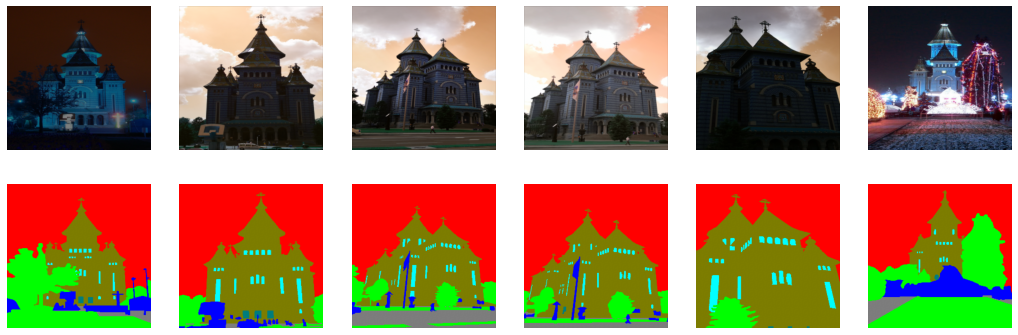

In [131]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();